In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import os

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# отображать по умолчанию длину Датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from Motorica_2 import *                                   

### <center>Чтение, анализ и предобработка данных</center>

In [30]:
import __init__
y_train_ = __init__.y_train
y_train_['sample']

0          0
1          0
2          0
3          0
        ... 
32296    322
32297    322
32298    322
32299    322
Name: sample, Length: 32300, dtype: int64



Еще одна гипотеза, на которой основана настоящая работа, состоит в том, что логистическая
регрессия, использованная для классификации жестов на первом этапе, должна достаточно
хорошо работать не только на перепадах средних показаний датчиков, но и на абсолютных 
показаниях, взятых для наблюдения в момент времени t.

То есть разбиваем решение задачи на два этапа:
- обучаем модель первого этапа для классификации жеста в каждый момент времени t на данных
начала и окончания каждого наблюдения (в те моменты времени, когда имеем для обучения "чистый"
жест),
- используем обученную модель для каждого последовательного момента времени в наблюдении из X_test. Считаем, 
что время t, когда наша модель перестала однозначно идентифицировать жест "начала" наблюдения и стала показывать возможность реализации другого - это и есть искомое время совершения жеста.

In [5]:
X_test = np.load('X_test.npy')
X_test.shape

(54, 40, 100)

К данному моменту модель уже была обучена один раз и определила классы жестов в X_test.
Стало понятно, что данные в X_test - это продолжение потока наблюдений из X_train. Для 
получения более четкой картины в моменте перехода, сразу добавляем к X_train данные из
X_test. Далее посмотрим, почему и как это работает.

In [34]:
X_train_ = np.load('X_train.npy')
X_train = np.concatenate([X_train_, X_test], axis=0)
X_train.shape

(377, 40, 100)

Соответственно, в y_train_upd.csv уже добавлены данные о жестах в нужном формате для наблюдений 323-376.

In [8]:
y_train_raw = pd.read_csv('y_train_upd.csv').reset_index(drop = True) #DataFrame
y_train_raw['sample'] = y_train_raw['sample-timestep'].apply(
                                    lambda x: int(x.split('-')[0]))
y_train_raw['timestep'] = y_train_raw['sample-timestep'].apply(
                                    lambda x: int(x.split('-')[1]))
y_train_raw.rename(columns={'class': 'Class'}, inplace=True)
y_train_raw   # 'sample-timestep', 'Class', 'sample', 'timestep'

,sample-timestep,Class,sample,timestep
0,0-0,0,0,0
1,0-1,0,0,1
2,0-2,0,0,2
3,0-3,0,0,3
...,...,...,...,...
37696,376-96,4,376,96
37697,376-97,4,376,97
37698,376-98,4,376,98
37699,376-99,4,376,99


Еще одна небольшая обработка - для каждого наблюдения зафиксированы жесты начала и окончания наблюдения,
т.е. из какого в какое состояние переходит кисть пилота.

In [10]:
y_train_gbge = pd.read_csv('y_train_gb_ge.csv').reset_index(drop = True)
y_train_gbge

,Id,Class begin,Class end
0,0,0,0
1,1,0,0
2,2,0,6
3,3,6,0
...,...,...,...
319,319,8,0
320,320,0,7
321,321,7,0
322,322,0,4


Т.к. для обучения классификации жестов нам нужна база со статическими
состояниями - обрезаем данные из X_train и y_train_raw. Исключаем из
них строки, относящиеся к интервалам времени, заданным в t_transit.

По предварительному анализу - это интервал времени [50:80].

Становится оправданным использование данных X_test для обучения - 
жесты для статических состояний мы уже определили на модели из первого
этапа.

In [11]:
t_transit = range(50, 80)
x_df = x_dataframe(X_train)
x_dftest = x_dataframe(X_test)
x_df_ot, y_ot = data_out_transit(x_df, y_train_raw, t_transit)
x_df_ot.shape

(26390, 40)

Обрезание базы для обучения - самое долгое преобразование, хорошо, что
его можно выполнить один раз в начале, а дальше использовать полученные
данные. Строк в базе осталось 377 наблюдений * 70 временных интервалов = 26390.

In [12]:
x_df_ot

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0-0,1123.0,10.0,1450.0,64.0,...,1677.0,36.0,718.0,26.0
0-1,1125.0,7.0,1441.0,66.0,...,1673.0,28.0,730.0,25.0
0-2,1121.0,17.0,1444.0,60.0,...,1670.0,29.0,727.0,27.0
0-3,1120.0,10.0,1440.0,59.0,...,1667.0,24.0,726.0,34.0
...,...,...,...,...,...,...,...,...,...
376-96,1884.0,17.0,1850.0,27.0,...,1668.0,29.0,315.0,29.0
376-97,1882.0,13.0,1843.0,37.0,...,1676.0,26.0,313.0,30.0
376-98,1886.0,14.0,1835.0,37.0,...,1673.0,27.0,318.0,32.0
376-99,1869.0,12.0,1820.0,36.0,...,1675.0,26.0,316.0,28.0


In [13]:
y_ot.shape

(26390, 4)

Для улучшения работы модели, а так же как альтернатива сглаживания датчиков
по времени, переведем их показания в категориальный признак. Разобьем
для каждого датчика диапазон его изменений на 11 интервалов. Выбор количества
интервалов обсудим в блоке с обсуждением итогов.

За ширину одного интервала возьмем показания 35й и 65й квантили распределения
показаний датчика при состоянии "open" (т.е. в наблюдениях жест "0" - жест "0"). 
Такой выбор квантилей позволяет закрыть 90% амплитуды колебаний датчика при 
раскрытом состоянии кисти тремя интервалами.

Анализ показаний датчиков выявил, что в использованном для наблюдений паттерне
жестов состояние жест "0" - жест "0" встречается каждый 18й и 19й раз. При
этом, каждый 18й раз на 60-70 моментах времени наблюдается необъяснимое
в рамках поставленной задачи движение. Поэтому для получения базовых
интервалов берем только каждое 18-е наблюдение, начиная со 2-го (т.е. 1, 19, 37 ...).

In [14]:
quantile_low, quantile_high = 35, 65
intervals = 11
zero_levels_st = zero_levels_stat(X_train, quantile_low, quantile_high)  
zero_levels_st  

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
median,1147.0,11.0,1229.00,24.0,...,1830.0,26.0,412.00,23.0
low,982.3,8.0,1131.65,20.0,...,1696.0,24.0,400.00,23.0
high,1224.0,13.0,1338.35,29.0,...,1866.0,27.0,474.35,24.0


Вывели статистические показатели low и high - квантили, на которых будем строить интервалы.

Создаем маску, которую используем для преобразования данных:

In [15]:
ss_mask = sensors_mask(zero_levels_st, intervals)

И, наконец, получаем данные для обучения в категориальном виде:

In [16]:
X_train_preproc = x_df_ot.reset_index(drop = True)
for s in range(40):
    X_train_preproc[f'sensor_{s}'] = X_train_preproc[f'sensor_{s}'].apply(lambda x: 
        compare_to_intervals(x, ss_mask[s], intervals))
X_train_preproc

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,4,4,5,8,...,3,8,8,7
1,4,3,5,9,...,3,5,8,6
2,4,5,5,8,...,3,5,8,8
3,4,4,5,8,...,3,4,8,10
...,...,...,...,...,...,...,...,...,...
26386,7,5,7,4,...,3,5,2,10
26387,7,5,7,5,...,3,4,2,10
26388,7,5,7,5,...,3,5,2,10
26389,7,4,7,5,...,3,4,2,9


In [17]:
X_test_preproc = x_dftest.reset_index(drop = True)
for s in range(40):
    X_test_preproc[f'sensor_{s}'] = X_test_preproc[f'sensor_{s}'].apply(lambda x: 
        compare_to_intervals(x, ss_mask[s], intervals))       # ss_mask
X_test_preproc

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,6,3,7,5,...,3,5,3,6
1,6,5,7,5,...,3,4,3,8
2,6,3,7,5,...,3,6,3,8
3,6,4,7,5,...,3,1,3,8
...,...,...,...,...,...,...,...,...,...
5396,7,5,7,4,...,3,5,2,10
5397,7,5,7,5,...,3,4,2,10
5398,7,5,7,5,...,3,5,2,10
5399,7,4,7,5,...,3,4,2,9


Приводим y_train к нужному формату.

In [18]:
y_train = pd.DataFrame(data=y_ot['Class'], columns=['Class']).reset_index(drop = True)
y_train = y_train['Class'].apply(int)
y_train

0        0
1        0
2        0
3        0
        ..
26386    4
26387    4
26388    4
26389    4
Name: Class, Length: 26390, dtype: int64

Посмотрим, как данные распределились по категориям. Конечно, больше всего точек
приходится на интервалы, соответствующие состоянию "open", но и другие интервалы
достаточно равномерно заполнены.

In [19]:
intervals_freq(X_train_preproc, intervals)

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,0,0,0,0,...,0,666,0,1066
1,0,0,2517,269,...,0,519,2,849
2,3436,2578,3012,1357,...,1462,1727,1516,1946
3,8360,5808,4478,5904,...,8934,4375,7279,4546
...,...,...,...,...,...,...,...,...,...
7,632,538,1264,1321,...,0,1159,2223,1561
8,199,133,499,846,...,0,419,1406,838
9,0,42,107,506,...,0,185,2070,1020
10,0,113,1367,349,...,0,240,1351,2765


In [20]:
intervals_freq(X_test_preproc, intervals)

,sensor_0,sensor_1,sensor_2,sensor_3,...,sensor_36,sensor_37,sensor_38,sensor_39
0,0,0,6,0,...,0,131,0,163
1,0,0,1152,43,...,0,120,2,120
2,1072,400,562,153,...,26,323,676,251
3,1809,908,838,1094,...,1121,874,1679,668
...,...,...,...,...,...,...,...,...,...
7,112,124,260,344,...,0,265,544,471
8,0,29,78,211,...,0,85,145,181
9,0,7,73,121,...,0,34,347,232
10,0,23,197,46,...,0,44,363,773


### <center>Тестирование и выбор модели</center>

### <center>Log</center>

На самом деле с выбором модели мы определились еще на первом этапе.
Логистическая регрессия достаточно хорошо выполняет задачу классификации
статической картинки. Как показало тестирование - применение коэффициентов
регуляризации и подбор других параметров влияют на результаты кросс-валидации
в четвертом знаке.

Более того, вынуждены отметить, что идеальные результаты при кросс-валидации
ведут к тому, что в паре наблюдений модель определяет 5й жест вместо 7-го и
1й вместо 2-го. Данная повторяющаяся ошибка связана, скорее всего, с
процессом сбора данных, т.к. модель, обученная совсем по другому принципу,
показывала аналогичные результаты.

Собственно, статические куски X_test для этого и были добавлены в обучение:
на данном этапе нам важнее поймать момент перехода из одного жеста в другой,
чем выявлять причину устойчивого определения "неправильного" жеста. 

После добавления данных X_test для обучения модели классификации жестов кросс-валидация и кривая обучения стали падать на последнем участке, но полученные выбросы достаточно хорошо убираются пост-обработкой на втором этапе, а общий результат предикта по двум задачам вместе получается более стабильным.

LogisticRegression(C=1, random_state=0, solver='saga')


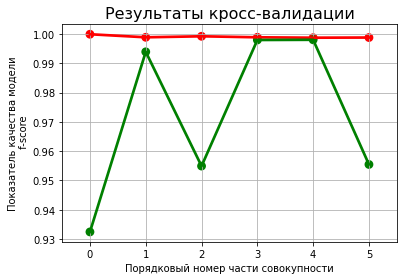

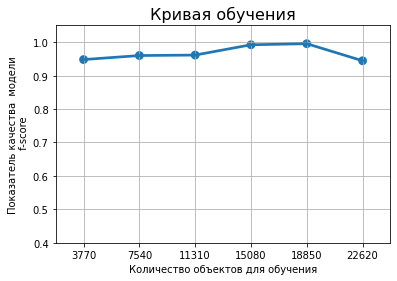


   cv_train   cv_test    cv_dif
0  0.999052  0.972098  0.026954



StratifiedKFold(n_splits=6, random_state=None, shuffle=False)

In [21]:
solver='saga'                                               # 'liblinear' 'saga' 'newton-cg'
C=1                                                         #  1, 10, 100, 500
n=6
cl = LogisticRegression(solver=solver, random_state=0, C=C)
stratified_cross_valid(cl, X_train_preproc, y_train, n, 'f1_macro') 
cv_splitter = StratifiedKFold(n_splits = n)
display(cv_splitter)

### <center>pre-Submition</center>

Получаем от обученной модели данные обработки X_test

In [22]:
cl = LogisticRegression(solver=solver, penalty='l2', random_state=42, C=1)
cl.fit(X_train_preproc, y_train.values.ravel())
sub_predict = cl.predict(X_test_preproc)

в виде вектора длиной 5400 значений классов - жестов

In [23]:
sub_predict

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

### <center>Постобработка</center>

Модель так же позволяет получить для каждого момента времени вероятности реализации каждого жеста. Выгружаем полученный из модели ряд вероятностей в формате:

наблюдение-время: вероятность реализации каждого жеста

In [24]:
ppr = pd.DataFrame(cl.predict_proba(X_test_preproc))
ppr['sample'] = pd.DataFrame([samp for samp in range(323, 377) for t in range(0, 100)])
ppr['timestep'] = pd.DataFrame([t for s in range(323, 377) for t in range(0, 100)])
#ppr.to_excel('predict_proba 50-80 30-70 i7 test.xlsx', index=False)

Если одна из вероятностей в строке более 80% - зануляем остальные показатели.

Если такого явного преимущества нет, оставляем ненулевыми все вероятности выше 30%.

In [25]:
ppr01 = pd.DataFrame(columns=[g for g in range(9)] + ['sample', 'timestep'])
for g in range(9):
    ppr01[g] = ppr[g].apply(lambda x: round(x, 6) if x >= 0.8 else 0)
for i in range(ppr01.shape[0]):
    if ppr01.iloc[i][:9].max() == 0:
        ppr01.iloc[i, :9] = ppr.iloc[i, :9].apply(lambda x: round(x, 6) 
                                                  if x >= 0.3 else 0)
        if ppr01.iloc[i][:9].max() == 0:
            print(f'All zeros in {i} row')
ppr01['sample'] = ppr['sample']
ppr01['timestep'] = ppr['timestep']
ppr01['class'] = None
ppr01.index = [f'{samp}-{t}' for samp in range(323, 377) for t in range(0, 100)]
ppr01.to_excel('predict_proba 5080 3565i11 02s2_ch.xlsx', index=False)

Дальнейшая обработка строится на следующем принципе:

если нет определенности в данный момент времени, запоминаем эти данные,
идем дальше, подтвержденным считаем тот жест, который в дальнейшем
однозначно реализовался на трех временных интервалах. Заполняем 
ретроспективно пропущенные ряды.

Время совершения жеста фиксируем на тот момент, в который предсказание
жеста стало отличным от первоначального.

In [27]:
def samp_predict(s):  # (samp)
    samp_list = ['' for _ in range(100)]
    set_cl_act, set_cl_act_new = set(), set()
    arr_cl = [[0 for _ in range(9)] for t in range(100)]
    dc = {}
    t_fact, t_tran = 0, 0

    for t in range(5):      # читаем первые 5 рядов для определения жеста-начала 
        for cl in range (9):
            if ppr01.loc[f'{s}-{t}', cl] > 0:
                set_cl_act.add(cl)
                arr_cl[t][cl] = 1  

    while True:
        set_cl_act_new = set_cl_act.copy()
        if len(set_cl_act_new) != 1:  # проверяем определенность жеста на 4 точках
            for cl in set_cl_act:
                if sum([arr_cl[t-tt][cl] for tt in range(4)]) == 0:
                    set_cl_act_new.discard(cl)
        if len(set_cl_act_new) == 1:  # если жест определен - заполняем предикт
            set_cl_act = set_cl_act_new.copy()
            cl_fact = list(set_cl_act)[0]
            for tt in range(0, t + 1):
                samp_list[tt] = cl_fact
            t_fact = t
            break                     # и переходим во 2й блок
        t += 1
        for cl in range (9):          # или читаем следующий ряд данных
            if ppr01.loc[f'{s}-{t}', cl] > 0:
                set_cl_act.add(cl)
                arr_cl[t][cl] = 1    

    while True:               # блок поиска времени перехода
        if t == 99 and t_tran == 0:  # наблюдение прочитано, а t transit не нашли
            if cl_fact != 0:        # и это не жест "0-0" - будем смотреть
                print(f'Look at {s} sample, t transit not found')
            else:
                for tt in range(t_fact + 1, t + 1):
                    samp_list[tt] = cl_fact
                if t_fact < 97:
                    print(f't fact = {t_fact}, {s} sample tail filled with zeros')
            break
#        if t > 51:
#            print(f't = {t} cl {set_cl_act}  arr = {arr_cl[t]}')
        t += 1
        for cl in range (9):
            if ppr01.loc[f'{s}-{t}', cl] > 0:
                set_cl_act.add(cl)
                arr_cl[t][cl] = 1        
        set_cl_act_new = set_cl_act.copy()
        if len(set_cl_act_new) != 1: # здесь для подтверждения жеста смотрим 3 ряда
            for cl in set_cl_act:
                if sum([arr_cl[t-tt][cl] for tt in range(3)]) == 0:
                    set_cl_act_new.discard(cl)
        if len(set_cl_act_new) == 1 and set_cl_act_new == {cl_fact}:
            set_cl_act = set_cl_act_new.copy()
            for tt in range(t_fact + 1, t + 1):
                samp_list[tt] = cl_fact
            t_fact = t
            continue
        if len(set_cl_act_new) == 1 and set_cl_act_new != {cl_fact}: 
            # если подтвержденный жест не равен начальному - фиксируем переход
            if not (set_cl_act_new != {0} and cl_fact != 0):
                set_cl_act = set_cl_act_new.copy()
                cl_fact = list(set_cl_act)[0]
                for tt in range(t_fact + 1, t + 1):
                    samp_list[tt] = cl_fact
                t_tran = t_fact + 1
                t_fact = t
                break
                    
    while t < 99:        # заполняем наблюдение до конца, подтверждая новый жест
        t += 1
        for cl in range (9):
            if ppr01.loc[f'{s}-{t}', cl] > 0:
                set_cl_act.add(cl)
                arr_cl[t][cl] = 1        
        set_cl_act_new = set_cl_act.copy()
        if len(set_cl_act_new) != 1:
            for cl in set_cl_act:
                if sum([arr_cl[t-tt][cl] for tt in range(3)]) == 0:
                    set_cl_act_new.discard(cl)
        if len(set_cl_act_new) == 1 and set_cl_act_new == {cl_fact}:
            set_cl_act = set_cl_act_new.copy()
            for tt in range(t_fact + 1, t + 1):
                samp_list[tt] = cl_fact
            t_fact = t
            continue            
        if len(set_cl_act_new) == 1 and set_cl_act_new != {cl_fact}:
            break    

    for tt in range(t + 1, 100):   # если новый жест определяется неоднозначно
                for cl in range (9):
                    if ppr01.loc[f'{s}-{t}', cl] > 0:
                        set_cl_act.add(cl)
                        arr_cl[t][cl] = 1
    if t_fact < 99 and t_tran > 50: # определяемся по количеству вероятностей  
        for cl in set_cl_act:       # реализации спорных жестов
            dc[cl] = 0
            for tt in range(t_fact + 1, 100):
                dc[cl] += arr_cl[t][cl]
        cl_end = max((v, k) for k, v in dc.items())[1]
        if cl_end == cl_fact:
            for tt in range(t_fact + 1, t + 1):
                samp_list[tt] = cl_fact
        else:
            for cl in set_cl_act:
                for tt in range(t_tran, t_fact):
                    dc[cl] += arr_cl[t][cl]
            cl_end = max((v, k) for k, v in dc.items())[1]
            if cl_end == cl_fact:
                for tt in range(t_fact + 1, t + 1):
                    samp_list[tt] = cl_fact
            else:
                print(f't fact = {t_fact}, refilled class a post, cl_fact = {cl_fact}')
                for tt in range(t_tran, 100):
                    samp_list[tt] = cl_end    

    if t_fact < 99 and t_tran == 0:  # жесты не однозначны, а t transit не нашли
        for cl in set_cl_act:        # тоже смотрим по вероятностям
            dc[cl] = 0
            for tt in range(t_fact + 1, 100):
                dc[cl] += arr_cl[t][cl]
        cl_end = max((v, k) for k, v in dc.items())[1]
        if cl_end == cl_fact:
            for tt in range(t_fact + 1, t + 1):
                samp_list[tt] = cl_fact
        else:
            t_tran = t_fact + 1
            for tt in range(t_fact + 1, 100):
                samp_list[tt] = cl_end
            print(f't tran = t fact = {t_tran}, refilled class a post, cl_fact = {cl_fact}')
            
    #print(f'class = {samp_list[0]}-{samp_list[99]}, {s} sample, t tran = {t_tran}')
    if samp_list[0] == '':      # выводим на печать, если есть ошибки заполнения
        print(f'Look at {s} sample, samp_list is empty')
    for t in range(1, t_tran):
        if samp_list[t] != samp_list[t-1]:
            print(f'Look at {s} sample, class[{t}] != class[{t-1}]')
    for t in range(t_tran + 1, 100):
        if samp_list[t] != samp_list[t-1]:
            print(f'Look at {s} sample, class[{t}] <> class[{t-1}]')
    if (samp_list[0] == samp_list[99] and samp_list[0] != 0) \
                or (samp_list[0] != 0 and samp_list[99] != 0):
        print(f'Look at {s} sample, class[0] = {samp_list[0]}, class[99] = {samp_list[99]}')
    
    return samp_list

#samp_predict(356)        

In [28]:
sub_predict = np.zeros(len(X_test)*100, dtype=np.int8) 
for samp in range(323, 377):   # 323, 377  # собираем предикты для всех наблюдений
    spredict = ['' for _ in range(100)]   
    spredict = samp_predict(samp)
    for t in range(100):
        sub_predict[(samp - 323) * 100 + t] = spredict[t]

t fact = 79, refilled class a post, cl_fact = 4
t fact = 77, refilled class a post, cl_fact = 5


Данные сообщения говорят о том, что на конец временного ряда в наблюдении не сформировалась
определенность в новом жесте по использованному принципу и данные были заполнены
на основании более частого предсказания данного жеста на интервале времени после
движения. 

In [29]:
submission = pd.read_csv(os.path.join('sample_submission.csv'))

submission['class'] = sub_predict     # выгрузка данных для сабмита

#submission.to_csv(os.path.join('sample_submission 5080 3565i11 02s2_ch.csv'), index = False)

### <center>Обсуждение</center>

Посмотрим на полученные результаты.
На рисунке ниже видим часть выгрузки вероятностей, полученной в ходе постобработки результатов работы обученной модели на X_test. Не смотря на то что модель упорно считает переход из "0" в "8" жест выполненным через несколько
"4"-х жестов, "момент" выхода из "0" жеста определяется достаточно четко. Возможно, такое "плавание" при классификации жестов связано
с фактическим исполнением жеста пилотом в этом наблюдении.

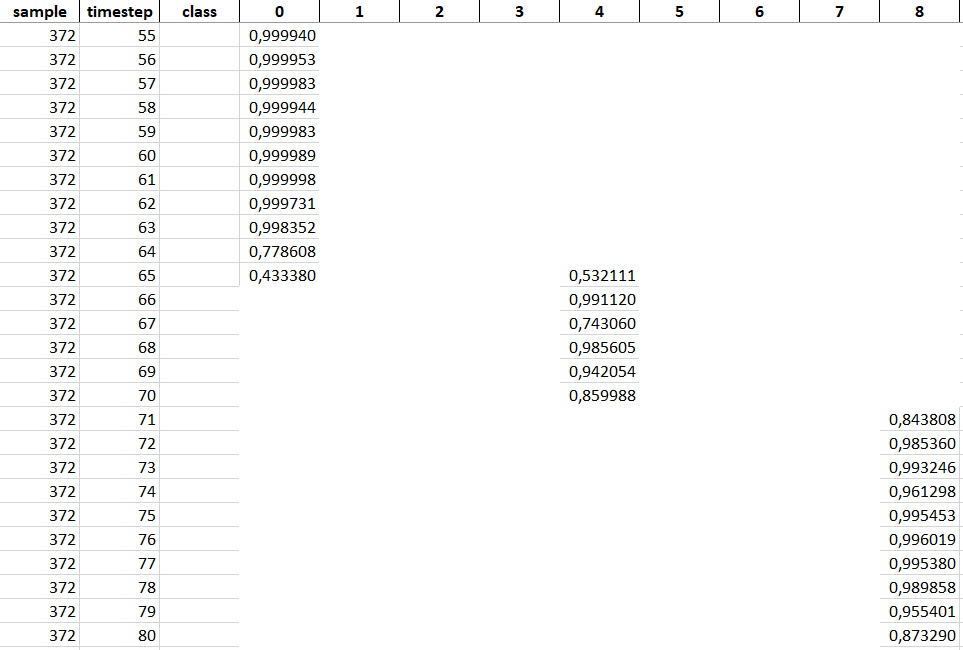

In [ ]:
display(Image('sample_372__gesture_08.png', width = 800))

Про выбор интервалов для категоризации данных.

Были получены результаты для количества интервалов, равного 5, 7, 9, 11. Улучшение скора между 9 и 11 
интервалами составило на Public  0,97407 - 0,9737 = 0,00037. Т.е. один временной тик на одном наблюдении.

По нашему мнению, достаточно хорошее предсказание можно получить при выделении 7-ми категориальных интервалов.

"Достаточно хорошее предсказание" означает следующее. Для определения качества работы модели организаторами предоставлен только один критерий - соответствие таргету на kaggle, соответственно, ориентируемся на доступный критерий. Между скорами 0,97407 и 1 разница составляет 0,02593. Разделим эту разницу на 0,00037 - скор на Public за улучшение ответа на 1 тик (1 / 5400 * 2 ). Получаем 70 точек, умножаем
на 2, чтобы учесть закрытую часть. Итого, наша ошибка составляет порядка 140 точек на 48 
наблюдениях (еще 6 - жесты "0-0", в них нельзя ошибиться с моментом перехода). В ходе работы с данными
мы понимаем, что "недоопределенные" точки более-менее равномерно распределены по всем наблюдениям. Это по 
3-4 тика "неточности" в определении достаточно абстрактного понятия "момента" на плавном изменении
датчиков при совершении движения. Думаем, что дальнейшее увеличение точности модели не имеет 
практической ценности.

### <center>Заключение</center>

Командой построена модель ML для решения задачи мультиклассовой классификации «распознавания жестов» и 
определения принципа поиска "момента" времени, в который можно зафиксировать совершенное движение.  
На этапе анализа данных приняты следующие гипотезы:
- для распознавания жеста в конкретный момент времени достаточно информации об абсолютных значениях датчиков,
- для обработки флуктуаций показаний датчиков вместо осреднения исходных данных по времени можно, при необходимости, убирать выбросы классификации при постобработке предиктов,
- для упрощения и повышения качества работы модели значения датчиков можно перевести в категории, разбив по интервалам,
- в качестве предиктора достаточно использовать логистическую регрессию,
- нужный момент времени определяется естественным путем в ходе работы модели как момент, в который модель начинает считать вероятным выполнение жеста, отличного от первоначального.  

Полученное решение хорошо согласуется с нашим представлением о структуре данных наблюдения и результатами предсказаний модели, построенной на принципах нейронной сети.

При относительной простоте самой модели и предобработки данных нам удалось обойтись без выбора математической гипотезы, которая бы детерменировала определение "момента" выполнения жеста. Мы получили данное значение в естественном ходе работы модели с достаточной для практического значения точностью.